# Cube Imaging 
This notebook will demonstrate how to create a cube dirty image with natural weighting using ngCASA. The resulting image will be compared with an image created by CASA. The Dask visualize tool will also be introduced.

For this demonstration data from the ALMA First Look at Imaging CASAguide (https://casaguides.nrao.edu/index.php/First_Look_at_Imaging) will be used. The measurement set has been converted to vis.zarr (using convert_ms in cngi.conversion).

This walkthrough is designed to be run in a Jupyter notebook on Google Colaboratory. To open the notebook in colab, go [here](https://colab.research.google.com/github/casangi/cngi_prototype/blob/master/docs/imaging/cube_imaging_example.ipynb).

## Installation and Dataset Download


In [1]:
import os

os.system("pip install --extra-index-url https://test.pypi.org/simple/ cngi-prototype==0.0.84")

!gdown -q --id 1fN3rdEQoeKExyIVBP87ZHdJTNuugkTJ0
!unzip sis14_twhya_chan_avg_field_5_lsrk_pol_xx.vis.zarr.zip > /dev/null

!gdown -q --id 1KpMk_BpRVsomnvPRYYAoaVByEhhgg2mU
!unzip casa_twhya_standard_gridder_lsrk_cube_natural.img.zarr.zip > /dev/null

#%matplotlib widget
print('complete') 

## Load Dataset

Two datasets are are needed for this notebook: 
- sis14_twhya_chan_avg_field_5_lsrk_pol_xx.vis.zarr
- casa_twhya_standard_gridder_lsrk_cube_natural.img.zarr 

(for more information about the img.zarr format go [here](https://cngi-prototype.readthedocs.io/en/latest/visibilities.html) and for the vis.zarr format go [here](https://cngi-prototype.readthedocs.io/en/latest/images.html)). 

The sis14_twhya_chan_avg_field_5_lsrk_pol_xx.vis.zarr dataset is used to create a cube image. The dataset was created by using the ```mstransform``` command in CASA

```python
mstransform('sis14_twhya_calibrated_flagged.ms',
            outputvis='sis14_twhya_chan_avg_field_5_lsrk_pol_xx.ms',
            regridms=True, outframe='LSRK', datacolumn='data',
            correlation='XX', field='5', nchan=7)
```

and then convert_ms in cngi.conversion

```python
infile = 'sis14_twhya_chan_avg_field_5_lsrk_pol_xx.ms'
outfile = 'sis14_twhya_chan_avg_field_5_lsrk_pol_xx.vis.zarr'
chunk_shape=(270, 210, 1, 1)
convert_ms(infile, outfile=outfile, chunk_shape=chunk_shape)
```

The conversion to 'LSRK' is necessary because cngi does not currently have an implementation and tclean does a conversion to 'LSRK' before imaging.

To check the ngcasa imaging results the casa_twhya_standard_gridder_lsrk_cube_natural.img.zarr dataset is used. This dataset was generated by running ```tclean``` in CASA

```python
tclean(vis='sis14_twhya_chan_avg_field_5_lsrk_pol_xx.ms',
       imagename='twhya_standard_gridder_lsrk_cube_natural',
       specmode='cube',
       deconvolver='hogbom',
       imsize=[200,400],
       cell=['0.08arcsec'],
       weighting='natural',
       threshold='0mJy',
       niter=0,stokes='XX')
```

and then ```image_ms``` in cngi.conversion

```python
infile = 'cube_image/twhya_standard_gridder_lsrk_cube_natural.image'
outfile = 'casa_twhya_standard_gridder_lsrk_cube_natural.img.zarr'
convert_image(infile=infile,outfile=outfile)
```

In [2]:
import xarray as xr
from cngi.dio import read_vis, read_image

xr.set_options(display_style="html")

mxds = read_vis("sis14_twhya_chan_avg_field_5_lsrk_pol_xx.vis.zarr")
print(mxds.xds0)

overwrite_encoded_chunks True
<xarray.Dataset>
Dimensions:         (baseline: 210, chan: 7, pol: 1, pol_id: 1, spw_id: 1, time: 270, uvw_index: 3)
Coordinates:
  * baseline        (baseline) int64 0 1 2 3 4 5 6 ... 204 205 206 207 208 209
  * chan            (chan) float64 3.725e+11 3.725e+11 ... 3.725e+11 3.725e+11
    chan_width      (chan) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    effective_bw    (chan) float64 dask.array<chunksize=(1,), meta=np.ndarray>
  * pol             (pol) int32 9
  * pol_id          (pol_id) int32 0
    resolution      (chan) float64 dask.array<chunksize=(1,), meta=np.ndarray>
  * spw_id          (spw_id) int32 0
  * time            (time) datetime64[ns] 2012-11-19T07:56:26.544000626 ... 2...
Dimensions without coordinates: uvw_index
Data variables: (12/17)
    ANTENNA1        (baseline) int32 dask.array<chunksize=(210,), meta=np.ndarray>
    ANTENNA2        (baseline) int32 dask.array<chunksize=(210,), meta=np.ndarray>
    ARRAY_ID        (tim

In [3]:
casa_img_xds = read_image("casa_twhya_standard_gridder_lsrk_cube_natural.img.zarr")
print(casa_img_xds)

<xarray.Dataset>
Dimensions:            (chan: 7, l: 200, m: 400, pol: 1, time: 1)
Coordinates:
  * chan               (chan) float64 3.725e+11 3.725e+11 ... 3.725e+11
    declination        (l, m) float64 dask.array<chunksize=(200, 400), meta=np.ndarray>
  * l                  (l) float64 3.879e-05 3.84e-05 ... -3.801e-05 -3.84e-05
  * m                  (m) float64 -7.757e-05 -7.718e-05 ... 7.679e-05 7.718e-05
  * pol                (pol) float64 9.0
    right_ascension    (l, m) float64 dask.array<chunksize=(200, 400), meta=np.ndarray>
  * time               (time) datetime64[ns] 2012-11-19T07:56:26.544000626
Data variables:
    IMAGE              (l, m, time, chan, pol) float64 dask.array<chunksize=(200, 400, 1, 1, 1), meta=np.ndarray>
    IMAGE_MASK0        (l, m, time, chan, pol) bool dask.array<chunksize=(200, 400, 1, 1, 1), meta=np.ndarray>
    IMAGE_PBCOR        (l, m, time, chan, pol) float64 dask.array<chunksize=(200, 400, 1, 1, 1), meta=np.ndarray>
    IMAGE_PBCOR_MASK0  (l

Note that the chunks parameter in cngi and ngcasa functions specifies the size of a chunk and not the number of chunks (in CASA ```tclean``` chanchunks refers to the number of channel chunks).

The dimensionality of the sis14_twhya_chan_avg_field_5_lsrk_pol_xx.vis.zarr dataset is (time:270,baseline:210,chan:7,pol:1) and a zarr chunk size of (time:270,baseline:210,chan:1,pol:1) was chosen. The dask chunk size was chosen to be the same as the zarr chunk size. For more information concerning chunking go to [here](https://cngi-prototype.readthedocs.io/en/latest/development.html).

## Flag Data and Create Imaging Weights 

The ```apply_flags``` cngi.vis function sets all values that should be flagged to nan. The ngcasa.imaging code does not internally apply flags but does ignore nan values. [apply_flags documentation](https://cngi-prototype.readthedocs.io/en/latest/_api/autoapi/cngi/vis/apply_flags/index.html#cngi.vis.apply_flags.apply_flags)

The ```make_imaging_weight``` cngi.imaging function takes the WEIGHT or WEIGHT_SPECTRUM data variables and creates IMAGING_WEIGHT data variable that has dimensions time x baseline x chan x pol (matches the visibility DATA variable). Weighting schemes that are supported include natural, uniform, briggs, briggs_abs. Using imaging_weights_parms['chan_mode'] = 'cube' is equivalent to perchanweightdensity=True in CASA. [make_imaging_weight documentation](https://cngi-prototype.readthedocs.io/en/latest/_api/autoapi/ngcasa/imaging/make_imaging_weight/index.html#ngcasa.imaging.make_imaging_weight.make_imaging_weight)


In [4]:
from cngi.vis import apply_flags
from ngcasa.imaging import make_imaging_weight

mxds = apply_flags(mxds, 'xds0', flags='FLAG')

grid_parms = {}
grid_parms['chan_mode'] = 'cube'
grid_parms['image_size'] = [200,400]
grid_parms['cell_size'] = [0.08,0.08]

sel_parms = {}
sel_parms['xds'] = 'xds0'
sel_parms['data_group_in_id'] = 0

imaging_weights_parms = {}
imaging_weights_parms['weighting'] = 'natural'

mxds =  make_imaging_weight(mxds, imaging_weights_parms, grid_parms, sel_parms)

print(mxds.xds0)

######################### Start make_imaging_weights #########################
Setting data_group_in  to  {'data': 'DATA', 'flag': 'FLAG', 'id': '0', 'uvw': 'UVW', 'weight': 'DATA_WEIGHT'}
Setting default data_group_out  to  {'data': 'DATA', 'flag': 'FLAG', 'id': '0', 'uvw': 'UVW', 'weight': 'DATA_WEIGHT', 'imaging_weight': 'IMAGING_WEIGHT'}
Since weighting is natural input weight will be reused as imaging weight.
######################### Created graph for make_imaging_weight #########################
<xarray.Dataset>
Dimensions:         (baseline: 210, chan: 7, pol: 1, pol_id: 1, spw_id: 1, time: 270, uvw_index: 3)
Coordinates:
  * baseline        (baseline) int64 0 1 2 3 4 5 6 ... 204 205 206 207 208 209
  * chan            (chan) float64 3.725e+11 3.725e+11 ... 3.725e+11 3.725e+11
    chan_width      (chan) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    effective_bw    (chan) float64 dask.array<chunksize=(1,), meta=np.ndarray>
  * pol             (pol) int32 9
  * pol_id  

## Create Dirty Cube Image
The ```make_image``` cngi.imaging function grids the data (using the prolate spheroidal function as an anti-aliasing filter), fast Fourier transform the gridded data to an image and normalizes the image. The ```make_pb``` function currently supports rotationally symmetric airy disk primary beams.

[make_pb documentation](https://cngi-prototype.readthedocs.io/en/latest/_api/autoapi/ngcasa/imaging/make_mosaic_pb/index.html#ngcasa.imaging.make_mosaic_pb.make_mosaic_pb)

[make_image documentation](https://cngi-prototype.readthedocs.io/en/latest/_api/autoapi/ngcasa/imaging/make_image/index.html#ngcasa.imaging.make_image.make_imagel)

To create an image of the execution graph the [dask.visualize]

######################### Start make_image #########################
Setting default image_center  to  [100 200]
Setting default fft_padding  to  1.2
Setting data_group_in  to  {'data': 'DATA', 'flag': 'FLAG', 'id': '0', 'uvw': 'UVW', 'weight': 'DATA_WEIGHT', 'imaging_weight': 'DATA_WEIGHT'}
Setting default data_group_out  to  {'data': 'DATA', 'flag': 'FLAG', 'id': '1', 'uvw': 'UVW', 'weight': 'DATA_WEIGHT', 'imaging_weight': 'DATA_WEIGHT'}
Setting default data_group_in  to  {'id': '0'}
Setting default data_group_out [' sum_weight ']  to  SUM_WEIGHT
Setting default data_group_out [' image ']  to  IMAGE
######################### Created graph for make_image #########################
######################### Start make_pb #########################
Setting default data_group_in  to  {'id': '0', 'sum_weight': 'SUM_WEIGHT', 'image': 'IMAGE'}
Setting default data_group_out  to  {'id': '0', 'sum_weight': 'SUM_WEIGHT', 'image': 'IMAGE', 'pb': 'PB'}
Setting default image_center  to  [100 200]


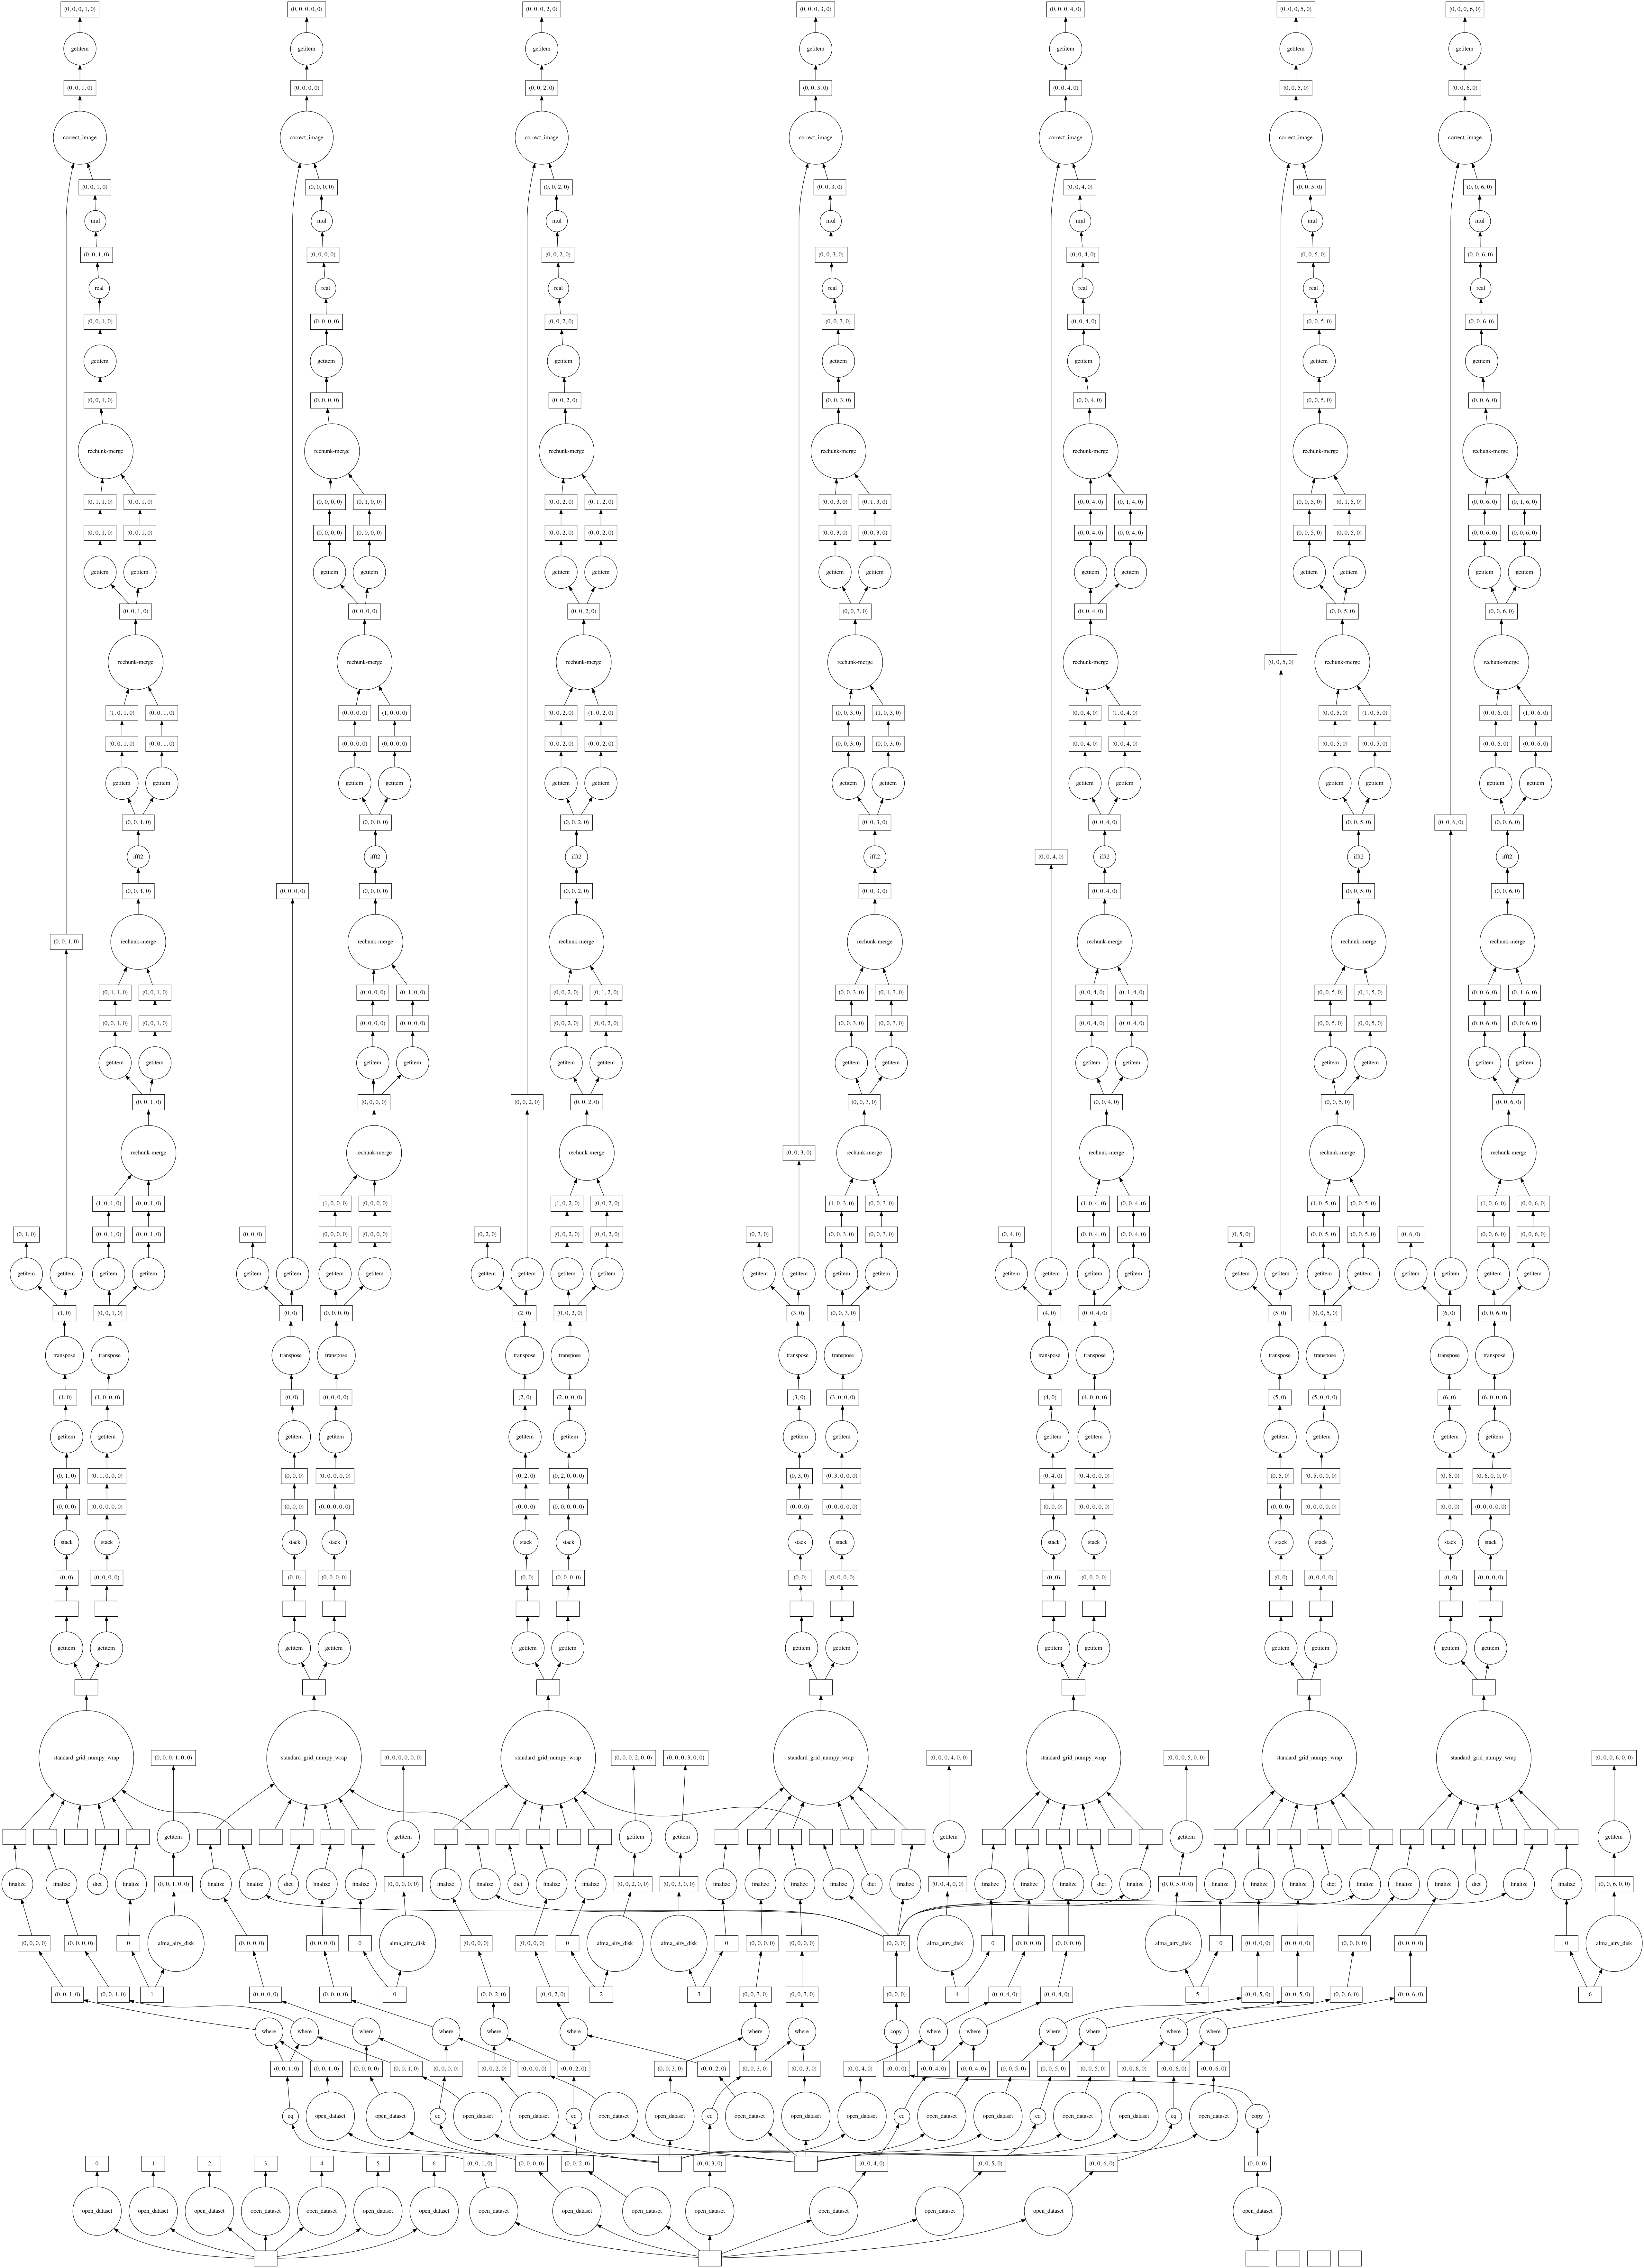

In [5]:
from ngcasa.imaging import make_image
from ngcasa.imaging import make_pb
from cngi.dio import write_image
import dask

grid_parms = {}
grid_parms['chan_mode'] = 'cube'
grid_parms['image_size'] = [200,400]
grid_parms['cell_size'] = [0.08,0.08]
grid_parms['phase_center'] = mxds.FIELD.PHASE_DIR[0,0,:].data.compute()

vis_sel_parms = {}
vis_sel_parms['xds'] = 'xds0'
vis_sel_parms['data_group_in_id'] = 0

img_sel_parms = {}
img_sel_parms['data_group_out_id'] = 0

img_xds = xr.Dataset() #empty dataset

img_xds = make_image(mxds, img_xds, grid_parms, vis_sel_parms, img_sel_parms)


make_pb_parms = {}
make_pb_parms['function'] = 'alma_airy'
make_pb_parms['list_dish_diameters'] = [10.7]
make_pb_parms['list_blockage_diameters'] = [0.75]

sel_parms = {}
sel_parms['img_description_in_indx'] = 0


img_xds = make_pb(img_xds,make_pb_parms, grid_parms, sel_parms)
dask.visualize(img_xds,filename='cube_image_graph.png')

## Dask Visualization

The Dask execution graph below shows how the images for each channel are computed in parallel. Each image is written to disk independently and Dask along with Zarr handles the virtual concatenation (the resulting img.zarr is chunked by channel). This allows for processing cubes that are larger than memory.

![title1](https://raw.githubusercontent.com/casangi/cngi_prototype/master/docs/imaging/cube_image_graph.png)

## Save Image to Disk (execute graph)

In [6]:
img_xds = write_image(img_xds, outfile='twhya_standard_gridder_lsrk_cube_natural.img.zarr', graph_name='make_imaging_weights, make_image and make_pb')

Time to store and execute graph  make_imaging_weights, make_image and make_pb 0.44735121726989746


## Plot and Compare With CASA

Frequency 372521853594.1145 Hz


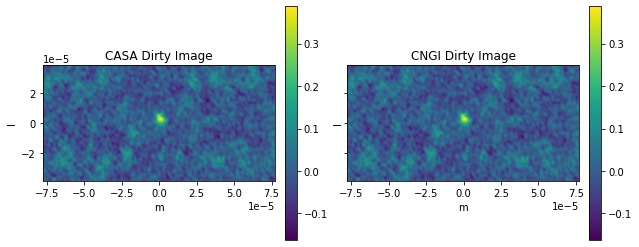

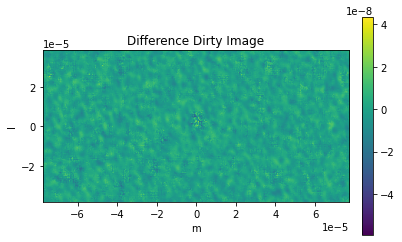

Max Error 1.662581979866573e-07
RMS Error 4.023737036016808e-06


In [7]:
import matplotlib.pylab as plt
import numpy as np
from ipywidgets import interactive
import xarray as xr


def comparison_plots_1(chan):
    img_xds = xr.open_zarr('twhya_standard_gridder_lsrk_cube_natural.img.zarr').isel(time=0,pol=0)
    casa_img_xds = read_image("casa_twhya_standard_gridder_lsrk_cube_natural.img.zarr").isel(time=0,pol=0)
    plt.close('all')
    print('Frequency',img_xds.chan[chan].values, 'Hz')
    #print(img_xds['IMAGE'])
    dirty_image = img_xds['IMAGE'].isel(chan=chan)
    casa_dirty_image = casa_img_xds['RESIDUAL'].isel(chan=chan)
    
    minmin = np.min([np.min(casa_dirty_image.data), np.min(dirty_image.data)])
    maxmax = np.max([np.max(casa_dirty_image.data), np.max(dirty_image.data)])
    extent = extent=(np.min(casa_dirty_image.m),np.max(casa_dirty_image.m),np.min(casa_dirty_image.l),np.max(casa_dirty_image.l))

    fig0, ax0 = plt.subplots(1, 2, sharey=True, figsize=(10, 5))
    im0 = ax0[0].imshow(casa_dirty_image,vmin=minmin,vmax=maxmax,extent=extent)
    im1 = ax0[1].imshow(dirty_image,vmin=minmin, vmax=maxmax,extent=extent)
    ax0[0].title.set_text('CASA Dirty Image')
    ax0[1].title.set_text('CNGI Dirty Image')
    ax0[0].set_xlabel('m'), ax0[1].set_xlabel('m'), ax0[0].set_ylabel('l'),ax0[1].set_ylabel('l')
    fig0.colorbar(im0, ax=ax0[0], fraction=0.046, pad=0.04)
    fig0.colorbar(im1, ax=ax0[1], fraction=0.046, pad=0.04)
    plt.show()

    plt.figure()
    plt.imshow(casa_dirty_image - dirty_image,extent=extent)
    plt.title('Difference Dirty Image')
    plt.xlabel('m')
    plt.ylabel('l')
    plt.colorbar(fraction=0.046, pad=0.04)
    plt.show()

    dirty_image = dirty_image / np.max(np.abs(dirty_image))
    casa_dirty_image = casa_dirty_image / np.max(np.abs(casa_dirty_image))

    # Calculate max error
    max_error_dirty_image = np.max(np.abs(dirty_image - casa_dirty_image)).values
    print('Max Error',max_error_dirty_image)
    # Calculate root mean square error
    rms_error_dirty_image = np.linalg.norm(dirty_image - casa_dirty_image, 'fro')
    print('RMS Error',rms_error_dirty_image)
    


#interactive_plot_1 = interactive(comparison_plots_1, chan=(0, 6))
#output_1 = interactive_plot_1.children[-1]
#output_1.layout.auto_scroll_threshold = 9999;
#interactive_plot_1

comparison_plots_1(3)

The first channel (channel 0) is flagged by both ngCASA and CASA. Why CASA is flagging the last channel and ngCASA is not, this needs further investigation. Checking sis14_twhya_chan_avg_field_5_lsrk_pol_xx.ms with browsetable in CASA shows that only the first channel is flagged.

The reason for the small difference between ngCASA and CASA, in channels 1 to 5, is due to ngCASA using a different implementation of the Fast Fourier Transform. 

Frequency 372521853594.1145 Hz


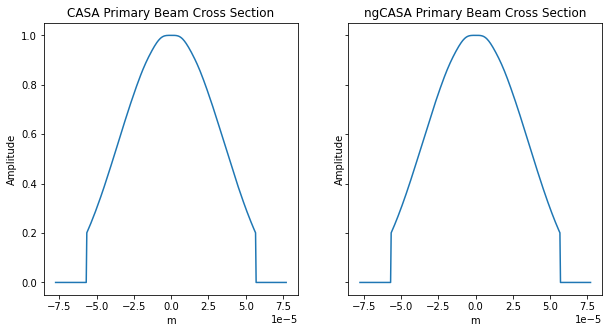

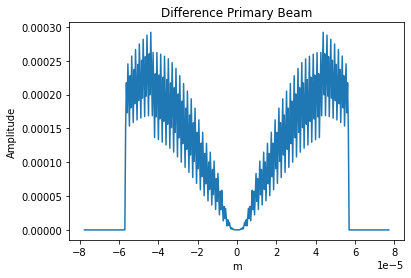

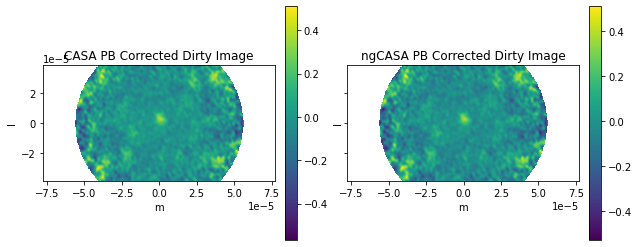

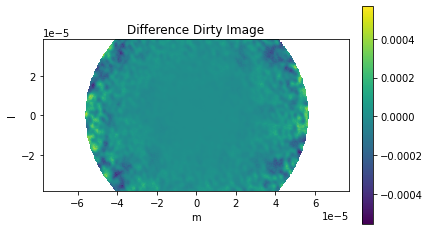

Max Normalized Error 0.06926086996721081
RMS Normalized Error 3.0796672817323736


In [8]:
import matplotlib.pylab as plt
import numpy as np
from ipywidgets import interactive


#### Primary Beam Corrected Images ####
def comparison_plots_2(chan):
    img_xds = xr.open_zarr('twhya_standard_gridder_lsrk_cube_natural.img.zarr').isel(time=0,pol=0, dish_type=0)
    casa_img_xds = read_image("casa_twhya_standard_gridder_lsrk_cube_natural.img.zarr").isel(time=0, pol=0)
    extent = extent=(np.min(casa_img_xds.m),np.max(casa_img_xds.m),np.min(casa_img_xds.l),np.max(casa_img_xds.l))
    
    plt.close('all')
    print('Frequency',img_xds.chan[chan].values, 'Hz')
    pb_limit = 0.2
    primary_beam = img_xds.PB.isel(l=100,chan=chan).where(img_xds.PB.isel(l=100,chan=chan) > pb_limit,other=0.0)
    dirty_image_pb_cor = img_xds.IMAGE.isel(chan=chan)/img_xds.PB.isel(chan=chan)
    dirty_image_pb_cor = dirty_image_pb_cor.where(img_xds.PB.isel(chan=chan) > pb_limit,other=np.nan)

    casa_primary_beam = casa_img_xds['PB'].isel(l=100,chan=chan) #Primary beam created by CASA
    casa_dirty_image_pb_cor = (casa_img_xds['IMAGE_PBCOR'].isel(chan=chan)).where(casa_img_xds['PB'].isel(chan=chan) > pb_limit,other=np.nan) #Image created by CASA


    #Plot Primary Beams
    fig0, ax0, = plt.subplots(1, 2, sharey=True,figsize=(10, 5))
    im0 = ax0[0].plot(casa_img_xds.m,casa_primary_beam)
    im1 = ax0[1].plot(casa_img_xds.m,primary_beam)
    ax0[0].title.set_text('CASA Primary Beam Cross Section')
    ax0[1].title.set_text('ngCASA Primary Beam Cross Section')
    ax0[0].set_xlabel('m'), ax0[1].set_xlabel('m')
    ax0[0].set_ylabel('Amplitude'), ax0[1].set_ylabel('Amplitude')
    plt.show()

    plt.figure()
    plt.plot(casa_img_xds.m,casa_primary_beam-primary_beam)
    plt.title('Difference Primary Beam')
    plt.xlabel('m')
    plt.ylabel('Amplitude')
    plt.show()

    #Plotting Images
    fig0, ax0 = plt.subplots(1, 2, sharey=True,figsize=(10, 5))
    im0 = ax0[0].imshow(casa_dirty_image_pb_cor,extent=extent)
    im1 = ax0[1].imshow(dirty_image_pb_cor,extent=extent)
    ax0[0].title.set_text('CASA PB Corrected Dirty Image')
    ax0[1].title.set_text('ngCASA PB Corrected Dirty Image')
    ax0[0].set_xlabel('m'), ax0[1].set_xlabel('m'), ax0[0].set_ylabel('l'), ax0[1].set_ylabel('l')
    fig0.colorbar(im0, ax=ax0[0], fraction=0.046, pad=0.04)
    fig0.colorbar(im1, ax=ax0[1], fraction=0.046, pad=0.04)
    plt.show()

    plt.figure()
    plt.imshow(casa_dirty_image_pb_cor - dirty_image_pb_cor,extent=extent)
    plt.title('Difference Dirty Image')
    plt.xlabel('m'), plt.ylabel('l')
    plt.colorbar(fraction=0.046, pad=0.04)
    plt.show()

    dirty_image_pb_cor = dirty_image_pb_cor / np.nanmax(np.abs(dirty_image_pb_cor))
    casa_dirty_image_pb_cor = casa_dirty_image_pb_cor / np.nanmax(np.abs(casa_dirty_image_pb_cor))
    norm_diff_image_pb_cor = dirty_image_pb_cor - casa_dirty_image_pb_cor

    # Calculate max error
    max_error_dirty_image = np.nanmax(np.abs(norm_diff_image_pb_cor))
    print('Max Normalized Error',max_error_dirty_image)
    # Calculate root mean square error
    rms_error_dirty_image = np.sqrt(np.nansum(np.square(norm_diff_image_pb_cor)))
    print('RMS Normalized Error',rms_error_dirty_image)


#interactive_plot_2 = interactive(comparison_plots_2, chan=(0, 6))
#output_2 = interactive_plot_2.children[-1]
#output_2.layout.auto_scroll_threshold = 9999;
#interactive_plot_2

comparison_plots_2(3)

The frequency does not change enough for the primary beam to vary significantly.

The difference in primary beam is due to CASA using a sampled 1D function while ngCASA calculates the PB for each pixel. If it is found that PB creation becomes a bottleneck for ngCASA the implementation will be changed to match CASA.

##  synthesis_imaging_cube function

The synthesis_imaging_cube is an standard gridder imager that combines the flagging and the creation of the imagining weights, primary beam, PSF, dirty image into a single function. The advantage of this function is that it simplifies the graph by combining functions that can reside in the same node.


In [13]:
%load_ext autoreload
%autoreload 2
from ngcasa.imaging import synthesis_imaging_cube
from cngi.dio import read_vis, write_image
import xarray as xr

mxds = read_vis("sis14_twhya_chan_avg_field_5_lsrk_pol_xx.vis.zarr")
print(mxds.xds0)

grid_parms = {}
grid_parms['chan_mode'] = 'cube'
grid_parms['image_size'] = [200,400]
grid_parms['cell_size'] = [0.08,0.08]
grid_parms['phase_center'] = mxds.FIELD.PHASE_DIR[0,0,:].data.compute()

imaging_weights_parms = {}
imaging_weights_parms['weighting'] = 'natural'
#imaging_weights_parms['weighting'] = 'briggs'
#imaging_weights_parms['robust'] = 0.5

vis_sel_parms = {}
vis_sel_parms['xds'] = 'xds0'
vis_sel_parms['data_group_in_id'] = 0

img_sel_parms = {}
img_sel_parms['data_group_out_id'] = 0

make_pb_parms = {}
make_pb_parms['function'] = 'alma_airy'
make_pb_parms['list_dish_diameters'] = [10.7]
make_pb_parms['list_blockage_diameters'] = [0.75]


img_xds2 = xr.Dataset()
img_xds2 = synthesis_imaging_cube(mxds, img_xds2, grid_parms, imaging_weights_parms, make_pb_parms, vis_sel_parms, img_sel_parms)
write_image(img_xds2, outfile='twhya_standard_gridder_lsrk_cube_natural2.img.zarr', graph_name='synthesis_imaging_cube')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
overwrite_encoded_chunks True
<xarray.Dataset>
Dimensions:         (baseline: 210, chan: 7, pol: 1, pol_id: 1, spw_id: 1, time: 270, uvw_index: 3)
Coordinates:
  * baseline        (baseline) int64 0 1 2 3 4 5 6 ... 204 205 206 207 208 209
  * chan            (chan) float64 3.725e+11 3.725e+11 ... 3.725e+11 3.725e+11
    chan_width      (chan) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    effective_bw    (chan) float64 dask.array<chunksize=(1,), meta=np.ndarray>
  * pol             (pol) int32 9
  * pol_id          (pol_id) int32 0
    resolution      (chan) float64 dask.array<chunksize=(1,), meta=np.ndarray>
  * spw_id          (spw_id) int32 0
  * time            (time) datetime64[ns] 2012-11-19T07:56:26.544000626 ... 2...
Dimensions without coordinates: uvw_index
Data variables: (12/17)
    ANTENNA1        (baseline) int32 dask.array<chunksize=(210,), meta=np.ndarray>
    ANTENNA2       

Frequency 372521853594.1145 Hz


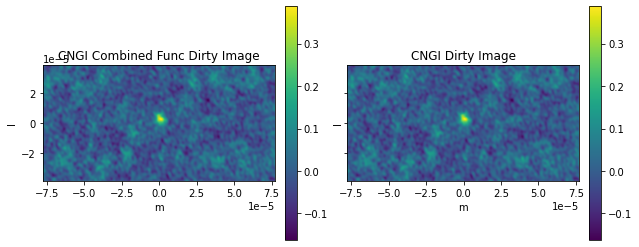

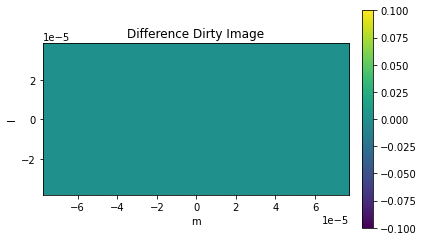

Max Error 0.0
RMS Error 0.0


In [14]:
import matplotlib.pylab as plt
import numpy as np
from ipywidgets import interactive
import xarray as xr


def comparison_plots_1(chan):
    img_xds = xr.open_zarr('twhya_standard_gridder_lsrk_cube_natural.img.zarr').isel(time=0,pol=0)
    img_xds2 = read_image("twhya_standard_gridder_lsrk_cube_natural2.img.zarr").isel(time=0,pol=0)
    plt.close('all')
    print('Frequency',img_xds.chan[chan].values, 'Hz')
    #print(img_xds['IMAGE'])
    dirty_image = img_xds['IMAGE'].isel(chan=chan)
    dirty_image2 = img_xds2['IMAGE'].isel(chan=chan)
    
    minmin = np.min([np.min(dirty_image2.data), np.min(dirty_image.data)])
    maxmax = np.max([np.max(dirty_image2.data), np.max(dirty_image.data)])
    extent = extent=(np.min(dirty_image2.m),np.max(dirty_image2.m),np.min(dirty_image2.l),np.max(dirty_image2.l))

    fig0, ax0 = plt.subplots(1, 2, sharey=True, figsize=(10, 5))
    im0 = ax0[0].imshow(dirty_image2,vmin=minmin,vmax=maxmax,extent=extent)
    im1 = ax0[1].imshow(dirty_image,vmin=minmin, vmax=maxmax,extent=extent)
    ax0[0].title.set_text('CNGI Combined Func Dirty Image')
    ax0[1].title.set_text('CNGI Dirty Image')
    ax0[0].set_xlabel('m'), ax0[1].set_xlabel('m'), ax0[0].set_ylabel('l'),ax0[1].set_ylabel('l')
    fig0.colorbar(im0, ax=ax0[0], fraction=0.046, pad=0.04)
    fig0.colorbar(im1, ax=ax0[1], fraction=0.046, pad=0.04)
    plt.show()

    plt.figure()
    plt.imshow(dirty_image2 - dirty_image,extent=extent)
    plt.title('Difference Dirty Image')
    plt.xlabel('m')
    plt.ylabel('l')
    plt.colorbar(fraction=0.046, pad=0.04)
    plt.show()

    dirty_image = dirty_image / np.max(np.abs(dirty_image))
    dirty_image2 = dirty_image2 / np.max(np.abs(dirty_image2))

    # Calculate max error
    max_error_dirty_image = np.max(np.abs(dirty_image - dirty_image2)).values
    print('Max Error',max_error_dirty_image)
    # Calculate root mean square error
    rms_error_dirty_image = np.linalg.norm(dirty_image - dirty_image2, 'fro')
    print('RMS Error',rms_error_dirty_image)
    


#interactive_plot_1 = interactive(comparison_plots_1, chan=(0, 6))
#output_1 = interactive_plot_1.children[-1]
#output_1.layout.auto_scroll_threshold = 9999;
#interactive_plot_1

comparison_plots_1(3)